# Laboratório 5: Reamostragem e Bootstrapping

Bem-vindo ao Laboratório 5! Nesta tarefa, desenvolveremos uma compreensão mais aprofundada sobre estimativa de parâmetros e inicialização, sobre a qual você pode aprender mais em [CIT 13](https://inferentialthinking.com/chapters/13/Estimation.html). As palestras relevantes são as Aulas 13, 17 e 18.

Você deve concluir todo este laboratório e enviá-lo ao Moodle até às 23h59 da data de vencimento.

In [57]:
# Descomente para executar no Colab
! pip install babypandas==0.1.8 --force-reinstall

  Using cached babypandas-0.1.8-py3-none-any.whl (14 kB)
  Using cached pandas-2.2.2-cp311-cp311-win_amd64.whl (11.6 MB)
  Using cached numpy-2.1.0-cp311-cp311-win_amd64.whl (12.9 MB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2024.1
    Uninstalling pytz-2024.1:
      Successfully uninstalled pytz-2024.1
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2024.1
    Uninstalling tzdata-2024.1:
      Successfully uninstalled tzdata-2024.1
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.0
    Uninstalling numpy-2.1.0:
      Successfully uni

ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'C:\\Users\\edubi\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\~-mpy.libs\\libscipy_openblas64_-c16e4918366c6bc1f1cd71e28ca36fc0.dll'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
# Imports
import numpy as np
import babypandas as bpd
import math



import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

from IPython.display import YouTubeVideo, IFrame

def show_bootstrapping_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vS_iYHJYXSVMMZ-YQVFwMEFR6EFN3FDSAvaMyUm-YJfLQgRMTHm3vI-wWJJ5999eFJq70nWp2hyItZg/embed?start=false&loop=false&delayms=3000"
    width = 600
    height = 320
    display(IFrame(src, width, height))

### Vídeo complementar sobre loops `for` e quando NÃO usá-los

Elaboramos um vídeo revisando algumas das maneiras de realizar tarefas repetitivas (por exemplo, amostragem aleatória, execução de operações em cada elemento de uma coluna) **sem** usar um loop `for`. Também veremos quando exatamente você precisa de um loop `for` nesta classe (executando um experimento muitas vezes). Isso é importante, porque usar um loop `for` quando não é necessário é uma **má** idéia, uma vez que o código resultante é bastante lento e difícil de debugar.

Se você está se sentindo um pouco confuso nas simulações de iteração e codificação, você pode dar uma olhada na revisão!

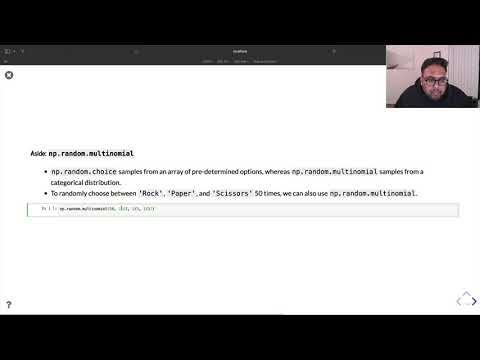

In [59]:
# Rode essa célula.
YouTubeVideo('BlczSBT80fU')

## 0. Percentis 🅿️

Antes de começarmos, precisamos apresentar o conceito de percentis. Os percentis associam números em um conjunto de dados às suas posições quando o conjunto de dados é classificado em ordem crescente.

Dada qualquer sequência (ou seja, lista, matriz ou série) de valores numéricos, imagine classificar os valores em ordem crescente para criar uma sequência classificada. Grosso modo, o $p$-ésimo percentil desta sequência é o valor que é $p$ por cento do caminho através da sequência. Por exemplo, o percentil 10 é apenas 10% do caminho (no início), o percentil 50 está na metade (no meio) e o percentil 90 é 90% do caminho (no final).

Existem muitas maneiras diferentes de definir com precisão um percentil. Nesta aula, consideraremos duas abordagens diferentes. Você deve pensar nisso como duas maneiras diferentes e separadas de definir um percentil. Eles nem sempre concordam!

### A definição matemática

> Seja $p$ um número entre 0 e 100. O $p$-ésimo percentil de uma coleção é o menor valor na coleção que é *pelo menos tão grande* quanto $p$% de todos os valores.

Com esta definição, qualquer percentil é sempre um elemento da coleção.

### A definição `numpy`

O pacote `numpy` fornece uma função `np.percentile` que recebe duas entradas: uma matriz de números e um valor `p`. Ele retorna um número que representa o `p`ésimo percentil da matriz. Você não precisa saber como ele calcula esse valor, mas você deve saber:
- nem sempre é igual à definição matemática dada acima (embora seja próxima), e
- nem sempre é um elemento do array.

#### Pergunta 0.1.

Digamos que você esteja em uma turma com 10 alunos e as notas de todos os alunos da turma estão armazenadas na matriz `grades`. Sua pontuação é 84.

In [60]:
grades = np.array([56, 65, 67, 72, 74, 78, 78, 80, 84, 94])

Qual das seguintes afirmações são verdadeiras? Use a definição matemática de percentil aqui.

1. A pontuação mais alta é o percentil 100.
2. Sua pontuação é superior ao percentil 80.
3. Sua pontuação é inferior ao percentil 81.
4. Sua pontuação é o 86º percentil.
5. Uma pontuação de 78 é o percentil 50.

Atribua `true_percentile` a uma `lista` contendo os números das afirmações verdadeiras.

In [61]:
true_percentile  = [grades.max() == np.percentile(grades, 100) , 84 > np.percentile(grades, 80), 84 < np.percentile(grades, 81), 84 == np.percentile(grades, 86), 76 == np.percentile(grades, 50)]
true_percentile

[np.True_, np.True_, np.False_, np.False_, np.True_]

#### Pergunta 0.2.
Use `np.percentile` para calcular o 50º percentil da matriz `grades` e salve o resultado como `p_50`.

In [62]:
p_50 = np.percentile(grades, 50)
p_50

np.float64(76.0)

#### Pergunta 0.3.
Use `np.median` para calcular o valor mediano da matriz `grades` e salve o resultado como `median_grade`.

**Manualmente** compare-o com sua resposta da Pergunta 0.2. Defina a variável `same` como `True` se os dois valores forem iguais e `False` se forem diferentes. Não use if/else para esta pergunta.

In [63]:
median_grade = np.median(grades)
print(median_grade)
same = p_50 == median_grade
same

76.0


np.True_

## 1. Preliminares da Inteligência Aliada 🧠

Ao longo deste laboratório, estudaremos um problema estatístico conhecido como [German tank problem](https://en.wikipedia.org/wiki/German_tank_problem).

Na Segunda Guerra Mundial, os Aliados (liderados pelos EUA, Reino Unido e União Soviética) queriam saber quantos tanques militares os alemães tinham produzido. No entanto, eles não conseguiram ver todos os tanques produzidos pelos alemães – em vez disso, tudo o que viram foi uma **amostra** aleatória de tanques.

Para enquadrar o problema com mais precisão, considere que os tanques receberam números de série que variam de 1 a `N`, onde `N` era o número total de tanques produzidos. Os Aliados estavam tentando estimar `N`, um **parâmetro populacional**, usando os números de série dos tanques em sua amostra. Assumiremos que a amostra dos Aliados é uma amostra aleatória simples da população (sorteada sem reposição).

<br>

<center><img src='https://raw.githubusercontent.com/dsc-courses/dsc10-2023-wi/0c3fbe39e35e9db8cc1716ec5feb8c2f325cc103/labs/lab05/images/tank.jpg' width=400></center>

<br>


Neste laboratório, dada **apenas** uma amostra aleatória de números de série, estimaremos `N` e, em seguida, usaremos a simulação para descobrir quão precisa é nossa estimativa, sem nunca olhar para toda a população. Este é um exemplo de **inferência estatística** – inferir algo sobre uma população usando apenas as informações de uma amostra.

**Pergunta 1.1.** `N` é um parâmetro populacional ou uma estatística?  Se calcularmos um número usando nossa amostra aleatória que é uma estimativa de `N`, isso é um parâmetro populacional ou uma estatística?  Atribua 1, 2, 3 ou 4 à variável `preliminaries_q1` abaixo.
1. `N` é um parâmetro populacional.  Uma estimativa de `N` de nossa amostra aleatória é um parâmetro populacional.
2. `N` é um parâmetro populacional.  Uma estimativa de `N` de nossa amostra aleatória é uma estatística.
3. `N` é uma estatística.  Uma estimativa de `N` de nossa amostra aleatória é um parâmetro populacional.
4. `N` é uma estatística.  Uma estimativa de `N` de nossa amostra aleatória é uma estatística.

In [64]:
preliminaries_q1 = 2

Para tornar a situação realista, vamos esconder de você o verdadeiro número de tanques.  Você terá acesso apenas a esta amostra aleatória:

In [65]:
observations = bpd.read_csv("https://raw.githubusercontent.com/dsc-courses/dsc10-2023-wi/main/labs/lab05/data/serial_numbers.csv")
num_observations = observations.shape[0]
observations

,serial_number
0,47
1,42
2,57
3,79
4,26
...,...
12,67
13,108
14,84
15,50


**Pergunta 1.2.** Defina uma função chamada `plot_serial_numbers` que desenha um histograma de qualquer DataFrame de números de série.  Deve levar um argumento, um DataFrame `df` com uma única coluna chamada `'serial_number'` (como `observations`).  Ele deve traçar um histograma dos valores na coluna `'serial_number'` **usando bins de largura 1** variando de **1 a 200 (inclusivo)** mas não retornar nada.  Em seguida, chame essa função para fazer um histograma de `observations`.

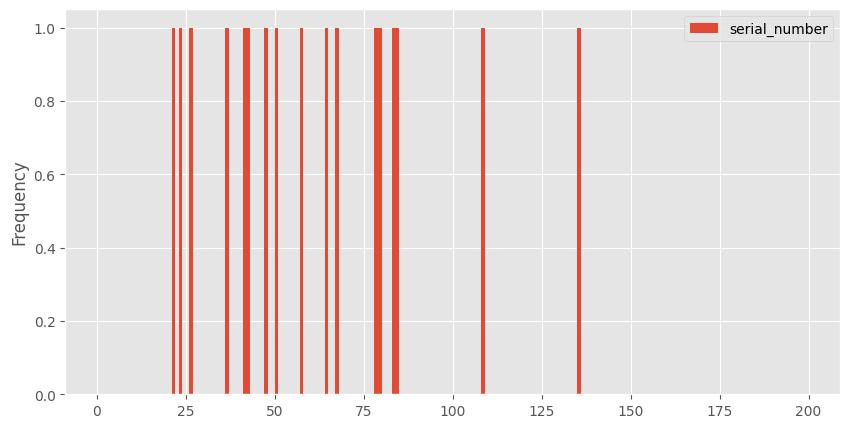

In [66]:
def plot_serial_numbers(df):
    df.plot(kind='hist', bins=np.arange(1, 200))

# Chame sua função.
plot_serial_numbers(observations)

***Verifique sua resposta***: Seu histograma deve ter barras com a mesma altura e o eixo x deve variar de 0 a 200.

**Pergunta 1.3.** Como estamos tentando estimar o máximo da população, `N`, uma estatística natural a ser usada é a amostra **max**. Em outras palavras, podemos estimar o número total de tanques como sendo o maior número de série da nossa amostra.

Abaixo, escreva uma função chamada `calculate_max_based_estimate` que calcula essa estatística em uma determinada série de números de série. Deve tomar como argumento uma série de números de série e retornar seu máximo.

Depois disso, use-o para calcular uma estimativa de `N` usando os números de série em `observações`. Chame a estimativa de `max_based_estimate`.

In [67]:
def calculate_max_based_estimate(nums):
    return nums.get("serial_number").max()

max_based_estimate = calculate_max_based_estimate(observations)
max_based_estimate

np.int64(135)

**Pergunta 1.4.** Outra maneira de estimar `N` é tomar **duas vezes a média** dos números de série em nossa amostra. Abaixo, escreva uma função chamada `calculate_mean_based_estimate` que calcula essa estatística. Deve tomar como argumento uma série de números de série e retornar o dobro da média.

Depois disso, use-o para calcular uma estimativa de `N` usando os números de série em `observações`. Chame a estimativa de `mean_based_estimate`.

In [68]:
def calculate_mean_based_estimate(nums):
    return nums.get("serial_number").mean() * 2

mean_based_estimate = calculate_mean_based_estimate(observations)
mean_based_estimate

np.float64(122.47058823529412)

**Pergunta 1.5.** Observe os valores de `max_based_estimate` e `mean_based_estimate` que obtivemos para nosso conjunto de dados:

In [69]:
max_based_estimate

np.int64(135)

In [70]:
mean_based_estimate

np.float64(122.47058823529412)

O valor de `max_based_estimate` diz algo sobre `mean_based_estimate`.  Poderia nossa atual `mean_based_estimate` possivelmente ser igual a `N` (pelo menos se arredondarmos para o número inteiro mais próximo)?  Se não, é definitivamente mais alto, definitivamente mais baixo, ou não podemos dizer?  Atribua uma das opções (1-6) à variável `preliminaries_q5` abaixo.
1. Sim, nossa `mean_based_estimate` para esta amostra pode ser igual a `N`.
2. Não, nossa `mean_based_estimate` para esta amostra não pode ser igual a `N`, é definitivamente menor em aproximadamente 3.
3. Não, nossa `mean_based_estimate` para esta amostra não pode ser igual a `N`, é definitivamente menor em pelo menos 12.
4. Não, nossa `mean_based_estimate` para esta amostra não pode ser igual a `N`, é definitivamente maior em aproximadamente 3.
5. Não, nossa `mean_based_estimate` para esta amostra não pode ser igual a `N`, é definitivamente maior em pelo menos 12.
6. Não, nossa `mean_based_estimate` para esta amostra não pode ser igual a `N`, mas não podemos dizer se é menor ou maior.

In [71]:
preliminaries_q5 = 3

Não podemos simplesmente proclamar com segurança que `max_based_estimate` ou `mean_based_estimate` são iguais a `N`, porque não sabemos o que `N` realmente é.  E se estivermos muito longe? Queremos ter uma noção da precisão de nossas estimativas.

## 2. Reamostragem 🥾

Se tivéssemos acesso a toda a população, poderíamos extrair repetidamente amostras da população e calcular a nossa estimativa utilizando cada amostra. Isto daria uma distribuição empírica de estimativas, que poderíamos usar para ver até que ponto as nossas estimativas tendem a ser erradas. Isso é o que fizemos na Aula 13.

Infelizmente, **não** temos acesso a toda a população (ou seja, não sabemos o valor de `N`). Tudo o que temos acesso é uma única amostra de números de série. Como podemos saber o quão precisas são as nossas estimativas sem sermos capazes de fazer amostras repetidas da população para criar uma distribuição empírica? 🤔

<br>

Uma estratégia é coletar repetidamente amostras de nossa amostra, ou "**reamostrar**", e usar essas reamostras para calcular uma distribuição empírica de nossa estimativa. Vamos falar sobre por que esta é uma estratégia razoável.
- Quando tentamos determinar `N`, o número de tanques, gostaríamos de usar toda a população.  Como tínhamos apenas uma amostra, usamos isso para estimar `N`.
- Da mesma forma, agora gostaríamos de usar a população de números de série para **executar uma simulação** para nos ajudar a entender como diferentes estimativas de `N` poderiam ter resultado. Mas ainda temos apenas nossa **amostra**, então podemos usá-la? **Podemos!**
- Como grandes amostras aleatórias se assemelham às populações das quais foram extraídas e nossa amostra é relativamente grande, podemos tratar nossa amostra como se fosse a população e tirar amostras dela.

Quando reamostramos a partir de nossa amostra original, amostramos **de maneira uniforme e aleatória com substituição** e criamos uma reamostragem **que tem o mesmo número de elementos que a amostra original**. (Na Questão 4, veremos por que devemos fazer uma nova amostragem com substituição.)

Aqui está uma analogia entre estimar `N` e simular a variabilidade de nossas estimativas:

$$\text{computar }N\text{ da população}$$
$$\text{está para}$$
$$\text{computar uma estimativa de }N\text{ a partir de uma amostra}$$

$$\text{assim como}$$

$$\text{simular a distribuição de estimativas de }N\text{ usando amostras da população}$$
$$\text{está para}$$
$$\text{simular uma distribuição (aproximada) de estimativas de }N\text{ usando reamostras de uma amostra}$$

O processo de reamostragem de nossa amostra original é conhecido como **reamostragem bootstrap**. Execute a célula abaixo para percorrer uma animação que ilustra como funciona o bootstrapping.

In [72]:
show_bootstrapping_slides()

**Bootstrapping é uma ideia realmente complicada, então peça ajuda se estiver confuso!**

**Questão 2.1.** Escreva uma função chamada `simulate_resample`.  Não deve receber argumentos e deve gerar uma nova amostra (novamente, **com substituição**) a partir dos números de série observados em `observations` e retornar essa nova amostra.  (A reamostragem deve ser um DataFrame como `observations`.)

_Dica:_ Use o método `.sample`.

In [73]:
def simulate_resample():
    return observations.sample(replace=True, n=observations.shape[0])

# Esse é um pequeno truque para garantir a reproducibilidade dos resultados,
# isto é, garantir que, embora usemos funções aleatórias (.sample), nós obtenhamos o mesmo resultado.
np.random.seed(123)

one_resample = simulate_resample()
one_resample

,serial_number
13,108
2,57
2,57
6,36
10,41
...,...
15,50
14,84
4,26
0,47


Posteriormente, usaremos muitas reamostras de uma vez para ver como normalmente são as estimativas.  Muitas vezes não prestamos atenção a reamostras únicas, por isso é fácil entendê-las mal.  Vamos examinar algumas reamostras individuais antes de começarmos a usá-las.

**Pergunta 2.2.** Faça um histograma de sua `one_resample` **e** um histograma separado das observações originais. Certifique-se de usar a função `plot_serial_numbers` que você definiu anteriormente no laboratório.

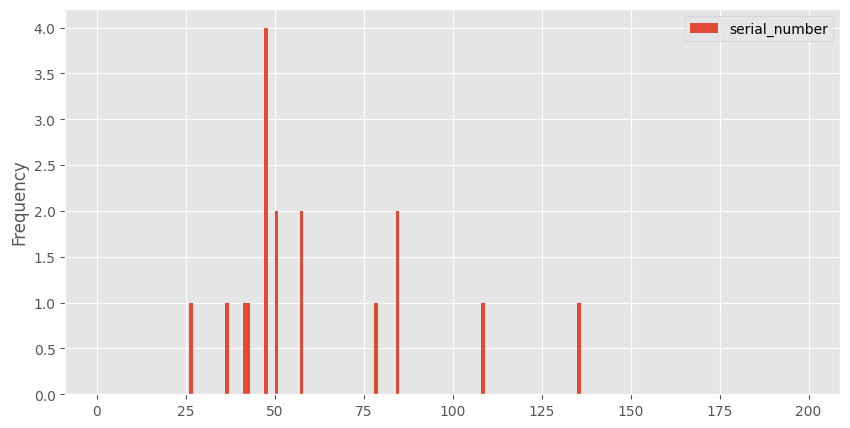

In [74]:
# Histograma da reamostragem.
plot_serial_numbers(one_resample)

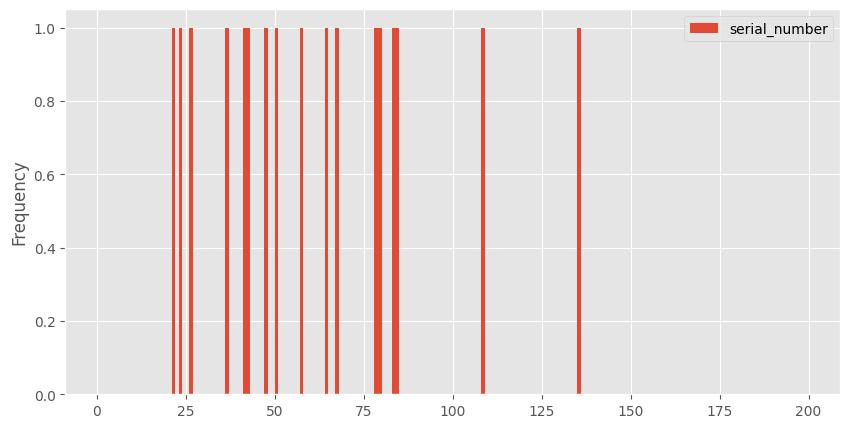

In [75]:
# Histogram das observações originais.
plot_serial_numbers(observations)

**Pergunta 2.3.** Quais das seguintes afirmações são verdadeiras:
1. No gráfico da reamostragem, não há barras em locais que não existiam no gráfico das observações originais.
2. No gráfico das observações originais, não há barras em locais que não existiam no gráfico da reamostragem.
3. Não há números de série duplicados na reamostra.
4. Não há números de série duplicados nas observações originais.

Atribua `true_statements` a uma lista de declarações corretas

In [76]:
true_statements = [True, False, False, True]

**Pergunta 2.4.** Crie mais 2 reamostras. Para cada reamostra, trace um histograma e calcule as estimativas baseadas no máximo e na média usando essa reamostra.

Estimativa baseada na média da reamostragem 1: 128.8235294117647
Estimativa baseada no máximo do reamostragem 1: 135


Estimativa baseada na média da reamostragem 2: 106.82352941176471
Estimativa baseada no máximo do reamostragem 2: 108




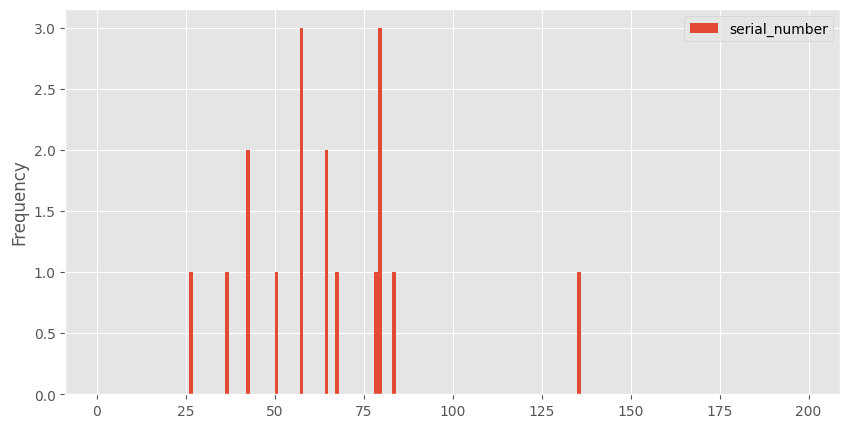

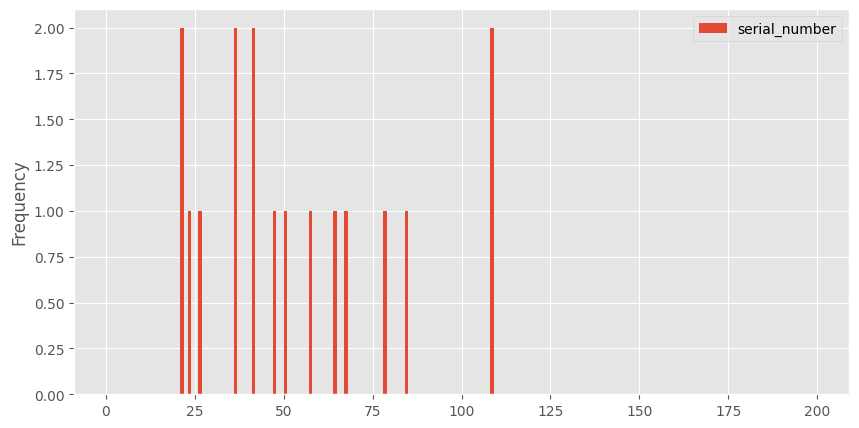

In [77]:
# np.arange(2) pois queremos dois resample. Também poderíamos usar range(2)
for i in np.arange(2):
    resample = observations.sample(replace=True, n=observations.shape[0])

    # Plote o histograma dessa reamostragem.
    plot_serial_numbers(resample)

    # Calcule as estimativas baseadas na média e no máximo da reamostragem.
    mean_based_estimate_resample = calculate_mean_based_estimate(resample)
    max_based_estimate_resample = calculate_max_based_estimate(resample)

    # Don't change the following 3 lines:
    print(f"Estimativa baseada na média da reamostragem {i+1}:", mean_based_estimate_resample)
    print(f"Estimativa baseada no máximo do reamostragem {i+1}:", max_based_estimate_resample)
    print('\n')

Há uma boa chance de você descobrir que as estimativas baseadas no máximo das reamostras são exatamente 135 (execute a célula algumas vezes e você quase certamente verá isso acontecer). Você provavelmente também descobrirá que as duas estimativas baseadas na média diferem da estimativa baseada na média da amostra (e uma da outra).

**Pergunta 2.5.** Calcule a probabilidade exata de que uma estimativa baseada no máximo de uma *reamostra* de nossa amostra de observações seja 135 e atribua-a à variável `resampling_q5` abaixo. Pode ser útil lembrar que o tamanho das “observações” é 17.

Observe que esta é uma questão de **matemática**, não de programação. Pode ser útil descobrir sua resposta no papel e então atribuir `resampling_q5` a uma expressão que avalie a resposta correta.

_Dica:_  Pense no exemplo da "vovó" da Aula 11. Qual é a probabilidade de qualquer um dos elementos em nossa reamostra ser igual a 135?

In [78]:
resampling_q5 = ...
resampling_q5

Ellipsis

A resposta correta é alta, acima de 60%. Pense por que é menos provável que uma estimativa baseada na média de uma reamostra seja exatamente igual à estimativa baseada na média da amostra original em comparação com uma estimativa baseada no máximo.

## 3. Reamostragem via Simulação 💻

Como a reamostragem de uma grande amostra aleatória se parece com a amostragem de uma população, o código também deve ser quase o mesmo. Isso significa que podemos escrever uma função que simule a amostragem de uma população ou a reamostragem de uma amostra.  Se lhe passarmos uma população como argumento, ele fará o primeiro; se passarmos uma amostra, ele fará o último.

**Questão 3.1.** Escreva uma função chamada `simulate_estimates`. Deve levar 4 argumentos:
- `original_df`: Um DataFrame do qual os dados devem ser amostrados, com 1 coluna chamada `'serial_number'`.
- `sample_size`: O tamanho de cada amostra, um número inteiro. (Por exemplo, para fazer a reamostragem, passaríamos o número de linhas em `original_df` para este argumento.)
- `statistic`: Uma **função** que calcula uma estatística em uma amostra. Este argumento é o **nome de uma função** que recebe uma série de números de série como argumento e retorna um número (por exemplo, `calculate_mean_based_estimate`).
- `repetitions`: O número de repetições a realizar (ou seja, o número de reamostras a criar).

Deve-se simular `repetitions` amostras **com substituição** do DataFrame fornecido. Para cada uma dessas amostras, deve-se calcular a estatística dessa amostra. Ento, deve-se retornar um array contendo o valor daquela estatística para cada amostra (isso significa que o comprimento do array retornado deve ser igual a `repetitions`).

O código abaixo fornece um exemplo de uso da sua função e descreve como você pode verificar se a escreveu corretamente.

***Verifique sua resposta***: O histograma que você vê deve ser uma curva em forma de sino centrada em 1000 com a maior parte de sua massa em [800, 1200].

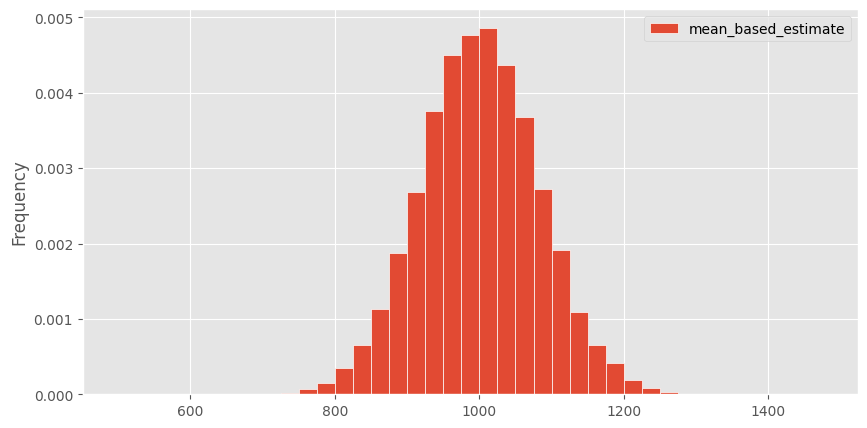

In [79]:
def simulate_estimates(original_df, sample_size, statistic, repetitions):
    stats = np.array([])

    for i in range(repetitions):
        resample = original_df.sample(n=sample_size, replace=True)
        stats = np.append(stats, statistic(resample))

    return stats

# Isso deve gerar um histograma empírico com estimativas de duas vezes a média
# de N exemplos de tamanho 50 se N for 1000. .
# Observe que o argumento da estatística é calculado usando calculate_mean_based_estimate.
example_estimates = simulate_estimates(
    bpd.DataFrame().assign(serial_number=np.arange(1, 1000+1)),
    50,
    calculate_mean_based_estimate,
    10000)
bpd.DataFrame().assign(mean_based_estimate = example_estimates).plot(kind = 'hist', density=True, bins=np.arange(500, 1500, 25), ec='w');

Agora podemos voltar à amostra que realmente observamos (`observations`) e estimar o quanto nossa estimativa de `N` baseada na média teria variado de amostra para amostra.

**Questão 3.2.** Usando o procedimento bootstrap e as `observações` de amostra, simule a distribuição aproximada de **estimativas baseadas em médias** de `N`. Use 5.000 repetições. Armazene as estimativas em `bootstrap_estimates`. (Observe que isso requer apenas uma linha de código; chame sua função `simulate_estimates`.)

Fornecemos um código que traça um histograma, permitindo visualizar as estimativas simuladas.

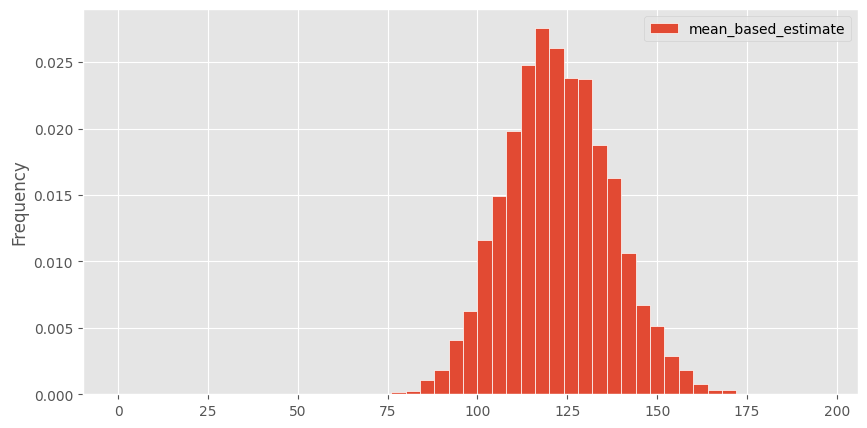

In [80]:
bootstrap_estimates = simulate_estimates(observations, observations.shape[0], calculate_mean_based_estimate, 5000)
bpd.DataFrame().assign(mean_based_estimate = bootstrap_estimates).plot(kind = 'hist', density=True, bins=np.arange(0, 200, 4), ec='w');

**Pergunta 3.3.** Calcule um intervalo que cubra os 95% intermediários das estimativas de bootstrap.  Verifique se o seu intervalo parece cobrir 95% da área no histograma acima.


_Dicas:_
- Use [`np.percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) aqui.
- Se você estiver usando 5 e 95 como argumentos para `np.percentile`, tente novamente – apenas 90% dos dados estão entre os percentis 5 e 95!

In [81]:
left_end = np.percentile(bootstrap_estimates, 2.5)
right_end = np.percentile(bootstrap_estimates, 97.5)
print("Meio 95% das estimativas do bootstrap: [{:f}, {:f}]".format(left_end, right_end))

Meio 95% das estimativas do bootstrap: [94.941176, 152.005882]


**Pergunta 3.4.** Digamos que `N`, o parâmetro populacional que estamos tentando estimar, seja na verdade 150. Escreva o código que simula o processo de amostragem e inicialização novamente, como segue:

1. Gere um novo conjunto de observações aleatórias que os Aliados possam ter visto por meio de amostragem do DataFrame populacional que criamos para você abaixo. Pegue uma amostra de tamanho 70 **sem reposição**. Armazene a amostra no nome da variável `new_observations`
2. Usando apenas `new_observations` – não `population` – calcule 5.000 estimativas bootstrap de `N` baseadas em média. Para fazer isso, chame sua função `simulate_estimates`.
3. Calcule um intervalo que cubra os 95% intermediários dessas estimativas baseadas na média.

In [82]:
population = bpd.DataFrame().assign(serial_number = np.arange(1, 150+1))
new_observations = population.sample(n=70,replace=False)
new_bootstrap_estimates = simulate_estimates(new_observations, 70, calculate_mean_based_estimate, 5000)

new_left_end = np.percentile(new_bootstrap_estimates, 2.5)
new_right_end = np.percentile(new_bootstrap_estimates, 97.5)

print("Meio 95% das estimativas do bootstrap: [{:f}, {:f}]".format(new_left_end, new_right_end))

Meio 95% das estimativas do bootstrap: [139.257143, 179.773571]


**Pergunta 3.5.** Se você executasse sua célula acima muitas e muitas vezes, aproximadamente qual porcentagem dos intervalos criados incluiria `N` (150 neste caso)?  Atribua 1, 2, 3, 4 ou 5 à variável `simulating_q5` abaixo.

1. 100%
2. 97.5%
3. 95%
4. 5%
5. É impossível dizer.

In [83]:
simulating_q5 = 3

## 4. Com ou sem reposição? 🔂

Cada vez que reamostramos nossa amostra original, amostramos **com reposição**. O que aconteceria se tentássemos reamostrar sem substituição? Vamos descobrir!

Abaixo, coletaremos outra amostra aleatória de tamanho 70 da `população` da qual poderemos reamostrar. Chamaremos isso de `original_sample`.

In [84]:
np.random.seed(23) #Para garantir que obtenhamos o mesmo resultado.
original_sample = population.sample(70)
original_sample

,serial_number
139,140
125,126
67,68
3,4
113,114
...,...
53,54
76,77
132,133
114,115


**Pergunta 4.1.** Abaixo, 5.000 vezes, colete uma nova amostra de tamanho 70 **de `original_sample` sem reposição**. Calcule a estimativa baseada na média em cada reamostra e armazene as estimativas na matriz `estimates_without_replacement`.

Nota: Você **não** pode usar sua função `simulate_estimates` aqui, porque ela faz amostras com substituição. Em vez disso, você terá que escrever um novo loop for. É uma boa ideia começar copiando o código da sua função no 3.1 e alterando as peças necessárias.

In [85]:
stats = np.array([])

for i in range(5000):
    resample = original_sample.sample(n=70, replace=False)
    stats = np.append(stats, calculate_mean_based_estimate(resample))
    
estimates_without_replacement = stats
estimates_without_replacement

array([149.51428571, 149.51428571, 149.51428571, ..., 149.51428571,
       149.51428571, 149.51428571])

**Pergunta 4.2.** Se você completou 4.1 corretamente, notará que todas as 5.000 estimativas são idênticas e equivalem a aproximadamente 149,5143. Além disso, este número é igual à estimativa baseada na média derivada de `amostra_original`, sem qualquer reamostragem:

In [86]:
calculate_mean_based_estimate(original_sample)

np.float64(149.5142857142857)

Por que todas as nossas estimativas são idênticas e por que **devemos** amostrar com reposição durante a reamostragem?

<!-- COMEÇAR PERGUNTA -->

<!--
COMEÇAR PERGUNTA
nome: q4_2
manual: verdadeiro
-->

Quando se reamostra sem reposição com tamanho amostral igual ao tamanho populacional, sempre se consegue o mesmo conjunto de valores que a população. Assim, a estimativa vai sempre ser a mesma, pois ela só depende dos valores obtidos.

<!-- FIM DA PERGUNTA -->



## Linha de chegada 🏁

Parabéns! Você concluiu o Laboratório 5.

Para enviar sua tarefa:

1. Selecione `Kernel -> Reiniciar e executar tudo` para garantir que você executou todas as células, incluindo as células de teste.
2. Leia o caderno para ter certeza de que está tudo bem e que todos os testes foram aprovados.
3. Baixe seu notebook usando `Arquivo -> Baixar como -> Notebook (.ipynb)` e, em seguida, carregue seu notebook para o Moodle.
